In [ ]:
%pylab inline
plt.style.use("bmh")

Populating the interactive namespace from numpy and matplotlib


In [ ]:
import pathlib
import pandas as pd

from sklearn.metrics import classification_report, f1_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
from tqdm import tqdm
tqdm.pandas()

In [ ]:
RS = 7345

# Загрузка данных

In [ ]:
DATA_DIR = pathlib.Path("../data/names/uploads")

In [ ]:
train = pd.read_csv("train.csv", index_col="pair_id")
test = pd.read_csv("test.csv", index_col="pair_id")

In [ ]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,Iko Industries Ltd.,"Enormous Industrial Trade Pvt., Ltd.",0
2,Apcotex Industries Ltd.,Technocraft Industries (India) Ltd.,0
3,"Rishichem Distributors Pvt., Ltd.",Dsa,0
4,Powermax Rubber Factory,Co. One,0
5,Tress A/S,Longyou Industries Park Zhejiang,0


In [ ]:
test.head()

,name_1,name_2
pair_id,,
1,Sun Blinds Decoration Inc.,Indl De Cuautitlan Sa Cv
2,Eih Ltd.,"Dongguan Wei Shi Plastic Product Co., Ltd."
3,Jsh Ltd. (Hk),Arab Shipbuilding And Repair Yard C
4,Better Industrial Ltd.,Farmacap Industria E Comercio Ltda
5,Equipos Inoxidables Del Norte Sa De Cv,Bel Inc.


In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 497819 entries, 1 to 497819
Data columns (total 3 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   name_1        497819 non-null  object
 1   name_2        497819 non-null  object
 2   is_duplicate  497819 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 15.2+ MB


In [ ]:
test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 213249 entries, 1 to 213249
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   name_1  213249 non-null  object
 1   name_2  213249 non-null  object
dtypes: object(2)
memory usage: 4.9+ MB


# Contries and cities

In [ ]:
cities = pd.read_csv("cities.csv", header=None, encoding='iso-8859-1')
cities.head(10)

,0,1,2,3
0,les Escaldes,les Escaldes,"Ehskal'des-Ehndzhordani,Escaldes,Escaldes-Engo...",AD
1,Andorra la Vella,Andorra la Vella,"ALV,Ando-la-Vyey,Andora,Andora la Vela,Andora ...",AD
2,Umm Al Quwain City,Umm Al Quwain City,"Oumm al Qaiwain,Oumm al Qaïwaïn,Um al Kawain,U...",AE
3,Ras Al Khaimah City,Ras Al Khaimah City,"Julfa,Khaimah,RAK City,RKT,Ra's al Khaymah,Ra'...",AE
4,Zayed City,Zayed City,"Bid' Zayed,Bid Zayed,Madinat Za'id,Madinat Za...",AE
5,Khawr Fakk?n,Khawr Fakkan,"Fakkan,Fakk?n,Khawr Fakkan,Khawr Fakk?n,Khawr ...",AE
6,Dubai,Dubai,"DXB,Dabei,Dibai,Dibay,Doubayi,Dubae,Dubai,Duba...",AE
7,Dibba Al-Fujairah,Dibba Al-Fujairah,"Al-Fujairah,BYB,Dibba Al-Fujairah,dba alfjyrt,...",AE
8,Dibba Al-Hisn,Dibba Al-Hisn,"BYB,Daba,Daba al-Hisn,Dab?,Dab? al-?i?n,Diba,D...",AE
9,Sharjah,Sharjah,"Al Sharjah,Ash 'Mariqah,Ash Shariqa,Ash Shariq...",AE


In [ ]:
stop_cities = []

# Companies

In [ ]:
companies = pd.read_csv("2020-11-19_elf-code-list-v1.3.csv")
companies[['Entity Legal Form name Local name', 'Entity Legal Form name Transliterated name (per ISO 01-140-10)']].head(10)

,Entity Legal Form name Local name,Entity Legal Form name Transliterated name (per ISO 01-140-10)
0,NaN,NaN
1,NaN,NaN
2,International Business Corporation,International Business Corporation
3,Sociedad Anonima,Sociedad Anonima
4,Sociedad Cooperativa,Sociedad Cooperativa
5,Sociedad Anonima Unipersonal,Sociedad Anonima Unipersonal
6,Stichting,Stichting
7,Vennootschap onder firma,Vennootschap onder firma
8,Commanditaire vennootschap (1),Commanditaire vennootschap (1)
9,Besloten vennootschap,Besloten vennootschap


In [ ]:
companies = companies[['Entity Legal Form name Local name', 'Entity Legal Form name Transliterated name (per ISO 01-140-10)']]

duplicate_companies = []
for i, (name_1, name_2) in companies.iterrows():
    if isinstance(name_1, str) and isinstance(name_2, str):
        if name_1 != name_2:
            duplicate_companies.append((name_1, name_2))
    

In [ ]:
duplicate_companies[:10]

[('Закрытае акцыянернае таварыства', 'Zakrytae akcyyanernae tavarystva'),
 ('Закрытое акционерное общество', 'Zakrytoe akcionernoe obshchestvo'),
 ('Унітарнае прадпрыемства', 'Unіtarnae pradpryemstva'),
 ('Унитарное предприятие', 'Unitarnoe predpriyatie'),
 ('Таварыства з абмежаванай адказнасцю',
  'Tavarystva z abmezhavanaj adkaznascyu'),
 ('Общество с ограниченной ответственностью',
  "Obshchestvo s ogranichennoj otvetstvennost'yu"),
 ('Таварыства з дадатковай адказнасцю', 'Tavarystva z dadatkovaj adkaznascyu'),
 ('Общество с дополнительной ответственностью',
  "Obshchestvo s dopolnitel'noj otvetstvennost'yu"),
 ('Адкрытае акцыянернае таварыства', 'Adkrytae akcyyanernae tavarystva'),
 ('Открытое акционерное общество', 'Otkrytoe akcionernoe obshchestvo')]

In [ ]:
rus2en = {'a': 'а', 'b': 'б'}

In [ ]:
len(duplicate_companies)

343

# Статистика таргета

In [ ]:
train.is_duplicate.value_counts()

0    494161
1      3658
Name: is_duplicate, dtype: int64

In [ ]:
train[train.is_duplicate==1].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
395382,Ikea Distribution Services Gmb H,Ikea Distribution Service(Shanghai),1
209566,Bridgestone Tire,Bridgestone (China) Research And Development C...,1
263594,Dow Chemical Thailand Ltd.,Dow Chemical Pacific,1
458214,Freudenberg Nok De Mexico Sa De Cv,Freudenberg Nok Componentes Brasil Ltda,1
388667,Arlanxeo Brasil Sa,Arlanxeo Singapore Pte.,1
158075,Basf Pakistan (Private) Ltd.,"Basf Co., Ltd.",1
163396,Soprema Canada,SOPREMA OBERROSSBACH,1
390723,"Sumitomo Rubber (Changshu) Co., Ltd.",Sumitomo Rubber Do Brasil Ltda,1
56580,Yokohama Tire Canada,Yokohama Re Mfg.,1


In [ ]:
train[train.is_duplicate==0].sample(15)

,name_1,name_2,is_duplicate
pair_id,,,
130514,R.H. Claydon Ltd.(Saxham),R.I.Intl,0
213799,Solid Cement,Lg Chem Ltd.,0
237941,Zara Brasil Ltd. Av Ribeirao Dos Cri,V.D.,0
62414,"Carlton Overseas Pvt., Ltd.",Infusion Overseas Private Ltd.,0
275797,Sportworx 2012 Ltd.,Elisei Nastri Trasportatori,0
138235,"Genius Industrial Supply Co., Ltd.",D S International,0
154412,Great Worldwide Logistics,Ez Logistics Llc,0
284958,Hps North America Inc.,Icl America Ltd.,0
150053,Gates India P. Ltd.,Indo Rama Synthetics (India) Ltd.,0


# Очистка данных

In [ ]:
!pip install pycountry

     |████████████████████████████████| 10.1MB 5.4MB/s 
  Created wheel for pycountry: filename=pycountry-20.7.3-py2.py3-none-any.whl size=10746865 sha256=bfcaab18323fc5b15af5af3b8f2727e9e877ac10156c580bd932cebc8c2be2d6
  Stored in directory: /root/.cache/pip/wheels/33/4e/a6/be297e6b83567e537bed9df4a93f8590ec01c1acfbcd405348
Successfully built pycountry


In [ ]:
import pycountry
import re

In [ ]:
countries = [country.name.lower() for country in pycountry.countries]

In [ ]:
train["name_1"] = train["name_1"].str.lower()
train["name_2"] = train["name_2"].str.lower()

test["name_1"] = test["name_1"].str.lower()
test["name_2"] = test["name_2"].str.lower()

In [ ]:
train[train.name_1.str.contains("gmbh")]

,name_1,name_2,is_duplicate
pair_id,,,
40,isoliererzeugnisse grobrohrsdorf gmbh,total rumunia,0
410,dortmunder gussasphalt gmbh & co. kg,bitoumina s.a.,0
440,celanese chemicals europe gmbh,inreco - emulsja sp. z o.o.,0
583,tremco illbruck group gmbh,wakol gmbh,0
681,rasco bitumentechnik gmbh,technpvinyl polymers india ltd.,0
...,...,...,...
497197,binne & sohn gmbh & co kg,buscher hoffmann,0
497306,mct gmbh & co. kg,valli zabban,0
497366,mct misch & compoundier technik gmbh,nknh,0


In [ ]:
legal_entities = ["ltd.", "co.", "inc.", "b.v.", "s.c.r.l.", "gmbh", "pvt."]

for entity in tqdm(legal_entities):
    train.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)
    test.replace(re.compile(f"\s+{entity}\s*"), "", inplace=True)

100%|██████████| 7/7 [00:14<00:00,  2.10s/it]


In [ ]:
train.head()

,name_1,name_2,is_duplicate
pair_id,,,
1,iko industries,"enormous industrial trade,",0
2,apcotex industries,technocraft industries (india),0
3,"rishichem distributors,",dsa,0
4,powermax rubber factory,co. one,0
5,tress a/s,longyou industries park zhejiang,0


In [ ]:
test.head()

,name_1,name_2
pair_id,,
1,sun blinds decoration,indl de cuautitlan sa cv
2,eih,"dongguan wei shi plastic product,"
3,jsh(hk),arab shipbuilding and repair yard c
4,better industrial,farmacap industria eercio
5,equipos inoxidables del norte sa de cv,bel


In [ ]:
train.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)
test.replace(re.compile(r"\s+\(.*\)"), "", inplace=True)

In [ ]:
for country in tqdm(countries):
    train.replace(re.compile(country), "", inplace=True)
    test.replace(re.compile(country), "", inplace=True)

100%|██████████| 249/249 [06:43<00:00,  1.62s/it]


In [ ]:
train.replace(re.compile(r"[^\w\s]"), "", inplace=True)
test.replace(re.compile(r"[^\w\s]"), "", inplace=True)

In [ ]:
train.sample(5)

,name_1,name_2,is_duplicate
pair_id,,,
361098,luis philipps saic gomas,pgm as,0
325757,rfe international,nazeer engineering,0
345992,hln rubber industries sdn bhd,sr industries,0
334673,molex private,continental private,0
226181,dongguan jiacun business and trade,island international,0


In [ ]:
test.sample(5)

,name_1,name_2
pair_id,,
15927,litrans logistica international de transportesepp,nrs logisticsas agent for
38955,apl logistics for,ares international logistics
63827,ubi banca,i b international
86003,beyond materials,chem trendercial sa de cv
168249,volkswagen private,sas engineering


# Lemmatizer

In [ ]:
import nltk
from nltk.stem import PorterStemmer, WordNetLemmatizer
from nltk.corpus import wordnet

nltk.download('wordnet')
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
lemmatizer = WordNetLemmatizer() #  lemmatizer.lemmatize(word)
stemmer = PorterStemmer() # stemmer.stem(word)

train['lemm_name_1'] = train['name_1'].apply(lambda sentence: ' '.join([lemmatizer.lemmatize(w) for w in sentence.rstrip().split()])) 
test['lemm_name_1']  = test['name_1'].apply(lambda sentence: ' '.join([lemmatizer.lemmatize(w) for w in sentence.rstrip().split()])) 

train['lemm_name_2'] = train['name_2'].apply(lambda sentence: ' '.join([lemmatizer.lemmatize(w) for w in sentence.rstrip().split()])) 
test['lemm_name_2']  = test['name_2'].apply(lambda sentence: ' '.join([lemmatizer.lemmatize(w) for w in sentence.rstrip().split()])) 

In [ ]:
from nltk.corpus import stopwords

en = stopwords.words("english")
rus = stopwords.words("russian")
stop_words = en + rus

train['stopw_name_1'] = train['lemm_name_1'].apply(lambda sentence: ' '.join([w for w in sentence.rstrip().split() if not w in stop_words])) 
test['stopw_name_1']  = test['lemm_name_1'].apply(lambda sentence: ' '.join([w for w in sentence.rstrip().split() if not w in stop_words])) 

train['stopw_name_2'] = train['lemm_name_2'].apply(lambda sentence: ' '.join([w for w in sentence.rstrip().split() if not w in stop_words])) 
test['stopw_name_2']  = test['lemm_name_2'].apply(lambda sentence: ' '.join([w for w in sentence.rstrip().split() if not w in stop_words])) 

In [ ]:
train.head()

,name_1,name_2,is_duplicate,lemm_name_1,lemm_name_2,stopw_name_1,stopw_name_2
pair_id,,,,,,,
1,iko industries,enormous industrial trade,0,iko industry,enormous industrial trade,iko industry,enormous industrial trade
2,apcotex industries,technocraft industries,0,apcotex industry,technocraft industry,apcotex industry,technocraft industry
3,rishichem distributors,dsa,0,rishichem distributor,dsa,rishichem distributor,dsa
4,powermax rubber factory,co one,0,powermax rubber factory,co one,powermax rubber factory,co one
5,tress as,longyou industries park zhejiang,0,tress a,longyou industry park zhejiang,tress,longyou industry park zhejiang


In [ ]:
train.to_csv('train_lemmatizer.csv', index=True)
test.to_csv('test_lemmatizer.csv', index=True)

In [ ]:
train = pd.read_csv('train_lemmatizer.csv')
test = pd.read_csv('test_lemmatizer.csv')
train.head()

,name_1,name_2,is_duplicate,lemm_name_1,lemm_name_2,stopw_name_1,stopw_name_2
0,iko industries,enormous industrial trade,0,iko industry,enormous industrial trade,iko industry,enormous industrial trade
1,apcotex industries,technocraft industries,0,apcotex industry,technocraft industry,apcotex industry,technocraft industry
2,rishichem distributors,dsa,0,rishichem distributor,dsa,rishichem distributor,dsa
3,powermax rubber factory,co one,0,powermax rubber factory,co one,powermax rubber factory,co one
4,tress as,longyou industries park zhejiang,0,tress a,longyou industry park zhejiang,tress,longyou industry park zhejiang


# CountVectorizer

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

documents = pd.concat([train['stopw_name_1'], train['stopw_name_2']]).values.astype('U')
count_vectorizer = CountVectorizer(max_features=1000) # memory limit: ngram_range=(2, 5),
values = count_vectorizer.fit_transform(documents)
frequency = values.toarray().sum(axis=0)

feature_names = count_vectorizer.get_feature_names()
count_train = pd.DataFrame({'feature_names': feature_names, 'frequency': frequency})

In [ ]:
# count_train = count_train.sort_values(by=['frequency'], ascending=False)
count_train.head(10)

,feature_names,frequency
433,international,96481
207,de,88605
421,industry,73258
736,sa,72389
900,trading,50473
508,logistics,49826
198,cv,46391
731,rubber,38804
672,private,33319
502,llc,31425


In [ ]:
count_train.to_csv('train_counter.csv', index=False)

# TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

documents = pd.concat([train['stopw_name_1'], train['stopw_name_2']]).values.astype('U')
tfidf_vectorizer = TfidfVectorizer(max_features=1000) # memory limit: ngram_range=(2, 5),
values = tfidf_vectorizer.fit_transform(documents)
frequency = values.toarray().sum(axis=0)

# Show the Model as a pandas DataFrame
feature_names = tfidf_vectorizer.get_feature_names()
tf_idf_train = pd.DataFrame({'feature_names': feature_names, 'frequency': frequency})

In [ ]:
tf_idf_train = tf_idf_train.sort_values(by=['frequency'], ascending=False)
tf_idf_train.head(10)

,feature_names,frequency
433,international,54241.109687
421,industry,45633.147254
736,sa,37276.041315
207,de,33893.185439
508,logistics,30495.161240
900,trading,30255.941137
731,rubber,22605.982851
672,private,22603.325698
198,cv,20228.930637
502,llc,17986.533492


In [ ]:
tf_idf_train.to_csv('train_tf_idf.csv', index=False)

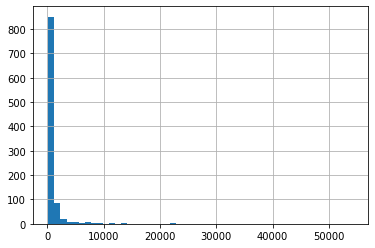

In [ ]:
tf_idf_train['frequency'].hist(bins=50)

(array([951.,  19.,   9.,   5.,   4.,   2.,   1.,   1.,   2.,   0.,   0.,
          2.,   1.,   1.,   0.,   0.,   1.,   0.,   0.,   1.]),
 array([  163.83206312,  2867.69594429,  5571.55982547,  8275.42370665,
        10979.28758783, 13683.15146901, 16387.01535019, 19090.87923136,
        21794.74311254, 24498.60699372, 27202.4708749 , 29906.33475608,
        32610.19863725, 35314.06251843, 38017.92639961, 40721.79028079,
        43425.65416197, 46129.51804314, 48833.38192432, 51537.2458055 ,
        54241.10968668]),
 <a list of 20 Patch objects>)

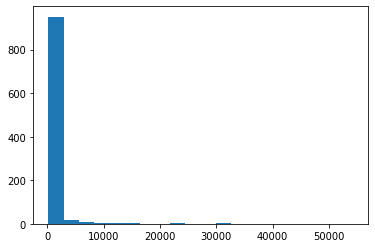

In [ ]:
import matplotlib.pyplot as plt

plt.hist(tf_idf_train['frequency'], bins=20)

# Delete popular words

In [ ]:
# remove 20% most popular words

perc = 0.2
size = int(len(count_train) * perc)

count_stop = count_train['feature_names'].iloc[:size].values
tf_idf_stop = tf_idf_train['feature_names'].iloc[:size].values

In [ ]:
train.dtypes

name_1          object
name_2          object
is_duplicate     int64
lemm_name_1     object
lemm_name_2     object
stopw_name_1    object
stopw_name_2    object
dtype: object

In [ ]:
popular_words = set(count_stop) | set(tf_idf_stop)

In [ ]:
train.fillna('', inplace=True)
test.fillna('', inplace=True)

In [ ]:
train['clean_name_1'] = train['stopw_name_1'].apply(lambda s: ' '.join([w for w in s.rstrip().split() if not w in popular_words])) 
train['clean_name_2'] = train['stopw_name_2'].apply(lambda s: ' '.join([w for w in s.rstrip().split() if not w in popular_words])) 

test['clean_name_1'] = test['stopw_name_1'].apply(lambda s: ' '.join([w for w in s.rstrip().split() if not w in popular_words]))
test['clean_name_2'] = test['stopw_name_2'].apply(lambda s: ' '.join([w for w in s.rstrip().split() if not w in popular_words])) 

In [ ]:
train[train.is_duplicate == True].head()

,name_1,name_2,is_duplicate,lemm_name_1,lemm_name_2,stopw_name_1,stopw_name_2,clean_name_1,clean_name_2
161,jx nippon oil gas exploration,jx nippon oil gas exploration technical servi...,1,jx nippon oil gas exploration,jx nippon oil gas exploration technical servic...,jx nippon oil gas exploration,jx nippon oil gas exploration technical servic...,jx nippon oil gas exploration,jx nippon oil gas exploration technical servic...
603,pirelli neumaticos saic,pirelli tyre,1,pirelli neumaticos saic,pirelli tyre,pirelli neumaticos saic,pirelli tyre,pirelli neumaticos saic,pirelli
835,brenntag,brenntag group,1,brenntag,brenntag group,brenntag,brenntag group,brenntag,brenntag
1328,paul bauderkg bochum plant,paul bauder ag,1,paul bauderkg bochum plant,paul bauder ag,paul bauderkg bochum plant,paul bauder ag,paul bauderkg bochum plant,paul bauder
1562,total ceska republika sro,total,1,total ceska republika sro,total,total ceska republika sro,total,ceska republika sro,


In [ ]:
train[train['lemm_name_2'] == ''].shape

(0, 9)

# Простые метрики сходства строк

In [ ]:
!pip install strsimpy

     |████████████████████████████████| 51kB 2.9MB/s 


In [ ]:
from strsimpy.levenshtein import Levenshtein
from strsimpy.normalized_levenshtein import NormalizedLevenshtein

In [ ]:
levenshtein = Levenshtein()

train["levenstein"] = train.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)
test["levenstein"] = test.progress_apply(lambda r: levenshtein.distance(r.name_1, r.name_2), axis=1)

100%|██████████| 213249/213249 [00:36<00:00, 5851.94it/s]


In [ ]:
train.head()

In [ ]:
normalized_levenshtein = NormalizedLevenshtein()

train["norm_levenstein"] = train.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                                axis=1)
test["norm_levenstein"] = test.progress_apply(lambda r: normalized_levenshtein.distance(r.name_1, r.name_2),
                                              axis=1)

100%|██████████| 213249/213249 [00:37<00:00, 5691.00it/s]


In [ ]:
train.head()

,name_1,name_2,is_duplicate,levenstein,norm_levenstein
pair_id,,,,,
1,iko industries,enormous industrial trade,0,15.0,0.600000
2,apcotex industries,technocraft industries,0,9.0,0.409091
3,rishichem distributors,dsa,0,20.0,0.909091
4,powermax rubber factory,co one,0,20.0,0.869565
5,tress as,longyou industries park zhejiang,0,26.0,0.812500


In [ ]:
test.head()

,name_1,name_2,levenstein,norm_levenstein
pair_id,,,,
1,sun blinds decoration,indl de cuautitlan sa cv,20.0,0.833333
2,eih,dongguan wei shi plastic product,29.0,0.906250
3,jshhk,arab shipbuilding and repair yard c,33.0,0.942857
4,better industrial,farmacap industria eercio,15.0,0.600000
5,equipos inoxidables del norte sa de cv,bel,35.0,0.921053


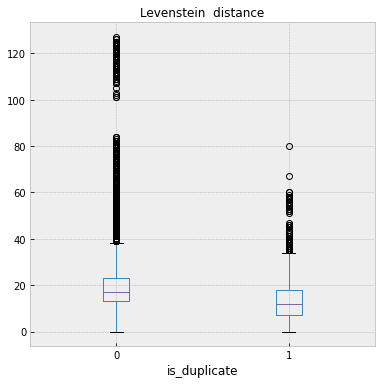

In [ ]:
plt.figure(figsize=(6,6))

train.boxplot("levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Levenstein  distance", fontsize=12);

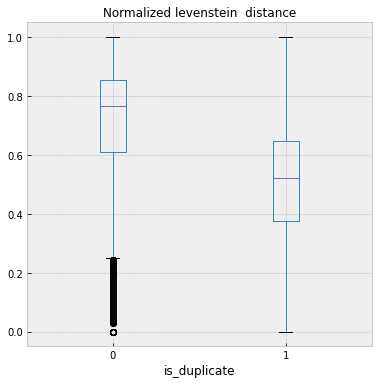

In [ ]:
plt.figure(figsize=(6,6))

train.boxplot("norm_levenstein", by="is_duplicate", ax=plt.gca())
plt.suptitle("")
plt.title("Normalized levenstein  distance", fontsize=12);

# Мои расстояния

In [ ]:
!pip install fuzzywuzzy

In [ ]:
from fuzzywuzzy import fuzz
from fuzzywuzzy import process

/usr/local/lib/python3.6/dist-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')


In [ ]:
train["partial_ratio"] = train.progress_apply(lambda r: fuzz.partial_ratio(r.name_1, r.name_2) / 100, axis=1)
test["partial_ratio"] = test.progress_apply(lambda r: fuzz.partial_ratio(r.name_1, r.name_2) / 100, axis=1)

train["token_sort_ratio"] = train.progress_apply(lambda r: fuzz.token_sort_ratio(r.name_1, r.name_2) / 100, axis=1)
test["token_sort_ratio"] = test.progress_apply(lambda r: fuzz.token_sort_ratio(r.name_1, r.name_2)  / 100, axis=1)

train["token_set_ratio"] = train.progress_apply(lambda r: fuzz.token_set_ratio(r.name_1, r.name_2) / 100, axis=1)
test["token_set_ratio"] = test.progress_apply(lambda r: fuzz.token_set_ratio(r.name_1, r.name_2) / 100, axis=1)

train["WRatio"] = train.progress_apply(lambda r: fuzz.WRatio(r.name_1, r.name_2) / 100, axis=1)
test["WRatio"] = test.progress_apply(lambda r: fuzz.WRatio(r.name_1, r.name_2) / 100, axis=1)

100%|██████████| 213249/213249 [02:05<00:00, 1704.92it/s]


In [ ]:
train["partial_ratio"] = train.progress_apply(lambda r: fuzz.partial_ratio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)
test["partial_ratio"] = test.progress_apply(lambda r: fuzz.partial_ratio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)

train["token_sort_ratio"] = train.progress_apply(lambda r: fuzz.token_sort_ratio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)
test["token_sort_ratio"] = test.progress_apply(lambda r: fuzz.token_sort_ratio(r.stopw_name_1, r.stopw_name_2)  / 100, axis=1)

train["token_set_ratio"] = train.progress_apply(lambda r: fuzz.token_set_ratio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)
test["token_set_ratio"] = test.progress_apply(lambda r: fuzz.token_set_ratio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)

train["WRatio"] = train.progress_apply(lambda r: fuzz.WRatio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)
test["WRatio"] = test.progress_apply(lambda r: fuzz.WRatio(r.stopw_name_1, r.stopw_name_2) / 100, axis=1)

 13%|█▎        | 28496/213249 [01:00<06:26, 478.62it/s]

# textdistance

In [ ]:
!pip install textdistance

In [ ]:
import textdistance as dist

In [ ]:
def normalize(values):
    return (values - values.min()) / (values.max() - values.min()) 

In [221]:
def calculate_distance(df, col_1, col_2, prefix=""):
    df[prefix + "jaccard"] = df.apply(lambda r: dist.jaccard(r[col_1], r[col_2]), axis=1)
    df[prefix + "cosine"]  = df.apply(lambda r: dist.cosine(r[col_1], r[col_2]), axis=1)
    df[prefix + "mra"]     = df.apply(lambda r: dist.mra(r[col_1], r[col_2]), axis=1)

    dist.jaro_winkler.external = False 
    df[prefix + "jaro_winkler"] = df.apply(lambda r: dist.jaro_winkler(r[col_1], r[col_2]), axis=1)

    df[prefix + "hamming"] = df.apply(lambda r: dist.hamming(r[col_1], r[col_2]), axis=1)
    df[prefix + "mlipns"]  = df.apply(lambda r: dist.mlipns(r[col_1], r[col_2]), axis=1)
    df[prefix + "damerau_levenshtein"] = df.apply(lambda r: dist.damerau_levenshtein(r[col_1], r[col_2]), axis=1)
    df[prefix + "strcmp95"] = df.apply(lambda r: dist.strcmp95(r[col_1], r[col_2]), axis=1)
    df[prefix + "needleman_wunsch"] = df.apply(lambda r: dist.needleman_wunsch(r[col_1], r[col_2]), axis=1)

    # error # df[prefix + "gotoh"] = df.apply(lambda r: dist.gotoh(r[col_1], r[col_2]), axis=1)
    df[prefix + "sorensen"] = df.apply(lambda r: dist.sorensen(r[col_1], r[col_2]), axis=1)
    df[prefix + "tversky"]  = df.apply(lambda r: dist.tversky(r[col_1], r[col_2]), axis=1)
    df[prefix + "overlap"]  = df.apply(lambda r: dist.overlap(r[col_1], r[col_2]), axis=1)
    #  many inf #df[prefix + "tanimoto"] = df.apply(lambda r: dist.tanimoto(r[col_1], r[col_2]), axis=1)
    df[prefix + "monge_elkan"] = df.apply(lambda r: dist.monge_elkan(r[col_1], r[col_2]), axis=1)
    
    df[prefix + "bag"]    = df.apply(lambda r: dist.bag(r[col_1], r[col_2]), axis=1)
    df[prefix + "lcsseq"] = df.apply(lambda r: dist.lcsseq(r[col_1], r[col_2]), axis=1)
    df[prefix + "lcsstr"] = df.apply(lambda r: dist.lcsstr(r[col_1], r[col_2]), axis=1)
    df[prefix + "ratcliff_obershelp"] = df.apply(lambda r: dist.ratcliff_obershelp(r[col_1], r[col_2]), axis=1)
    return df

In [ ]:
train.head()

,name_1,name_2,is_duplicate,lemm_name_1,lemm_name_2,stopw_name_1,stopw_name_2,clean_name_1,clean_name_2
0,iko industries,enormous industrial trade,0,iko industry,enormous industrial trade,iko industry,enormous industrial trade,iko,enormous
1,apcotex industries,technocraft industries,0,apcotex industry,technocraft industry,apcotex industry,technocraft industry,apcotex,technocraft
2,rishichem distributors,dsa,0,rishichem distributor,dsa,rishichem distributor,dsa,rishichem distributor,
3,powermax rubber factory,co one,0,powermax rubber factory,co one,powermax rubber factory,co one,powermax factory,
4,tress as,longyou industries park zhejiang,0,tress a,longyou industry park zhejiang,tress,longyou industry park zhejiang,tress,longyou park


In [223]:
train = calculate_distance(train, col_1='clean_name_1', col_2='clean_name_2', prefix='clean_')
test  = calculate_distance(test, col_1='clean_name_1', col_2='clean_name_2', prefix='clean_')

train = calculate_distance(train, col_1='lemm_name_1', col_2='lemm_name_2', prefix='lemm_')
test  = calculate_distance(test, col_1='lemm_name_1', col_2='lemm_name_2', prefix='lemm_')

In [224]:
train.to_csv('train_dist.csv', index=True)
test.to_csv('test_dist.csv', index=True)

# Мои модели

C norm_levenstein - максимально 0.27 на пороге 0.85
Без него 0.38 на пороге 0.9

In [175]:
FTS = train.loc[:, train.dtypes != 'object'].columns.values
FTS = np.delete(FTS, np.where(FTS == 'is_duplicate'))

In [176]:
FTS

array(['cleanjaccard', 'cleancosine', 'cleanmra', 'cleanjaro_winkler',
       'cleanhamming', 'cleanmlipns', 'cleandamerau_levenshtein',
       'cleanstrcmp95', 'cleanneedleman_wunsch', 'cleansorensen',
       'cleantversky', 'cleanoverlap', 'cleantanimoto',
       'cleanmonge_elkan', 'cleanbag', 'cleanratcliff_obershelp',
       'lemm_sorensen', 'lemm_tversky', 'lemm_overlap', 'lemm_tanimoto',
       'lemm_monge_elkan', 'lemm_bag', 'lemm_ratcliff_obershelp'],
      dtype=object)

In [177]:
# FTS = ["partial_ratio", "token_sort_ratio", "token_set_ratio", "WRatio"]
THR = 0.9

In [179]:
split = StratifiedShuffleSplit(1, train_size=0.8, random_state=42)
tridx, cvidx = list(split.split(train[FTS], train["is_duplicate"]))[0]

In [195]:
model = LogisticRegression(class_weight="balanced", max_iter=500)
model.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=500, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

clf = RandomForestClassifier(random_state=42)
parameters = {'criterion' : ['gini', 'entropy'],
              'n_estimators' : [50, 100, 200, 300, 500],
              'max_depth': [2, 3, 5, 7, 9],
              'max_features': ['auto', 'sqrt', 'log2'],
            #   'class_weight': ['balanced', 'balanced_subsample']
              }
cv = GridSearchCV(clf, parameters, scoring='f1', cv=3)
cv.fit(train.iloc[tridx][FTS].values, train.iloc[tridx]["is_duplicate"].values)
print(cv.best_score_, cv.best_params_)


# clf.fit(train.iloc[tridx][FTS].values, train.iloc[tridx]["is_duplicate"].values)

In [196]:
def choose_thr(model, train, tridx, cvidx):
    tr_preds = model.predict_proba(train.iloc[tridx][FTS].values)
    cv_preds = model.predict_proba(train.iloc[cvidx][FTS].values)

    for thr in np.arange(0.5, 1, 0.05):
        tr_pred = (tr_preds[:, 1] > thr).astype(np.int)
        cv_pred = (cv_preds[:, 1] > thr).astype(np.int)

        print("thr =", thr, f1_score(train.iloc[tridx]["is_duplicate"].values, tr_pred))
        print("thr =", thr, f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_pred))

In [ ]:
# rfc = 
choose_thr(model, train, tridx, cvidx)

In [197]:
# logistic regression with default params
choose_thr(model, train, tridx, cvidx)

thr = 0.5 0.0765595784463709
thr = 0.5 0.07717614804660727
thr = 0.55 0.08974358974358976
thr = 0.55 0.0915682967959528
thr = 0.6000000000000001 0.10594689715853216
thr = 0.6000000000000001 0.10764693490625657
thr = 0.6500000000000001 0.12466001813236628
thr = 0.6500000000000001 0.12353174079450968
thr = 0.7000000000000002 0.14973571192599933
thr = 0.7000000000000002 0.1494949494949495
thr = 0.7500000000000002 0.1814124023593177
thr = 0.7500000000000002 0.1817789291882556
thr = 0.8000000000000003 0.22969148032833284
thr = 0.8000000000000003 0.22604284103720407
thr = 0.8500000000000003 0.29258630447085454
thr = 0.8500000000000003 0.2838903492301915
thr = 0.9000000000000004 0.3511983620378177
thr = 0.9000000000000004 0.3494387506100537
thr = 0.9500000000000004 0.3759168704156479
thr = 0.9500000000000004 0.38289962825278806


In [ ]:
tr_preds = model.predict_proba(train.iloc[tridx][FTS].values)
cv_preds = model.predict_proba(train.iloc[cvidx][FTS].values)

for thr in np.arange(0.5, 1, 0.05):
    tr_pred = (tr_preds[:, 1] > thr).astype(np.int)
    cv_pred = (cv_preds[:, 1] > thr).astype(np.int)

    print("thr =", thr, f1_score(train.iloc[tridx]["is_duplicate"].values, tr_pred))
    print("thr =", thr, f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_pred))

thr = 0.5 0.04444945848375451
thr = 0.5 0.0450729450393642
thr = 0.55 0.04764859429158287
thr = 0.55 0.04782737968823005
thr = 0.6000000000000001 0.051907449910055206
thr = 0.6000000000000001 0.05205264191710862
thr = 0.6500000000000001 0.06104809050138887
thr = 0.6500000000000001 0.06102737619194094
thr = 0.7000000000000002 0.07705787006614974
thr = 0.7000000000000002 0.07738919667590027
thr = 0.7500000000000002 0.10032351883925361
thr = 0.7500000000000002 0.10167310167310166
thr = 0.8000000000000003 0.17763257863546572
thr = 0.8000000000000003 0.18252776943860705
thr = 0.8500000000000003 0.3360323886639676
thr = 0.8500000000000003 0.3521505376344086
thr = 0.9000000000000004 0.37960220059246724
thr = 0.9000000000000004 0.3882845188284519
thr = 0.9500000000000004 0.0
thr = 0.9500000000000004 0.0


In [ ]:
thr = 0.9
tr_preds = model.predict_proba(train.iloc[tridx][FTS].values)
cv_preds = model.predict_proba(train.iloc[cvidx][FTS].values)

tr_preds = (tr_preds[:, 1] > thr).astype(np.int)
cv_preds = (cv_preds[:, 1] > thr).astype(np.int)

print(f1_score(train.iloc[tridx]["is_duplicate"].values, tr_preds))
print(f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

0.37960220059246724
0.3882845188284519


Best threshold = 0.85

# Базовая модель

In [ ]:
FTS = ["levenstein", "norm_levenstein"]
THR = 0.9

In [ ]:
split = StratifiedShuffleSplit(1, train_size=0.8, random_state=RS)
tridx, cvidx = list(split.split(train[FTS], train["is_duplicate"]))[0]

In [ ]:
model = LogisticRegression(class_weight="balanced")
model.fit(train.iloc[tridx][FTS].values,
          train.iloc[tridx]["is_duplicate"].values)

LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [ ]:
tr_preds = model.predict_proba(train.iloc[tridx][FTS].values)
cv_preds = model.predict_proba(train.iloc[cvidx][FTS].values)

In [ ]:
tr_preds = (tr_preds[:, 1] > THR).astype(np.int)
cv_preds = (cv_preds[:, 1] > THR).astype(np.int)

In [ ]:
print(classification_report(train.iloc[tridx]["is_duplicate"].values, tr_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99    395329
           1       0.17      0.13      0.15      2926

    accuracy                           0.99    398255
   macro avg       0.58      0.56      0.57    398255
weighted avg       0.99      0.99      0.99    398255



In [ ]:
print(classification_report(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

              precision    recall  f1-score   support

           0       0.99      1.00      0.99     98832
           1       0.17      0.14      0.15       732

    accuracy                           0.99     99564
   macro avg       0.58      0.57      0.57     99564
weighted avg       0.99      0.99      0.99     99564



In [ ]:
print(f1_score(train.iloc[tridx]["is_duplicate"].values, tr_preds))
print(f1_score(train.iloc[cvidx]["is_duplicate"].values, cv_preds))

0.14792338327327895
0.15128593040847202


# Генерация сабмита

In [201]:
sample_sub = pd.read_csv("sample_submission.csv", index_col="pair_id")

In [202]:
THR = 0.95

In [225]:
sample_sub["is_duplicate"] = (model.predict_proba(test[FTS].values)[:, 1] > THR).astype(np.int)

In [ ]:
sample_sub.is_duplicate.value_counts()

0    210909
1      2340
Name: is_duplicate, dtype: int64

In [226]:
sample_sub.is_duplicate.value_counts()

0    211378
1      1871
Name: is_duplicate, dtype: int64

In [228]:
sample_sub.to_csv("my_submission_2.csv")